# Make multiwavelength light curves using archival data
***

## Learning Goals    
By the end of this tutorial, you will be able to:
 - automatically load a catalog of sources
 - automatically search NASA and non-NASA resources for light curves
 - store light curves in a Pandas multiindex dataframe
 - plot all light curves on the same plot
 
 
## Introduction:
 - A user has a sample of interesting targets for which they would like to see a plot of available archival light curves.  We start with a small set of changing look AGN from Yang et al., 2018, which are automatically downloaded. Changing look AGN are cases where the broad emission lines appear or disappear (and not just that the flux is variable). 
 - We model light curve plots after van Velzen et al. 2021.  We search through a curated list of time-domain NASA holdings as well as non-NASA sources.  HEASARC catalogs used are Fermi and Beppo-Sax, IRSA catalogs used are ZTF and WISE, and MAST catalogs used are Pan-Starrs, TESS, Kepler, and K2.  Non-NASA sources are Gaia and IceCube. This list is generalized enough to include many types of targets to make this notebook interesting for many types of science.  All of these time-domain archives are searched in an automated fashion using astroquery or APIs.
 - Light curve data storage is a tricky problem.  Currently we are using a multi-index Pandas dataframe, as the best existing choice for right now.  One downside is that we need to manually track the units of flux and time instead of relying on an astropy storage scheme which would be able to do some of the units worrying for us (even astropy can't do all magnitude to flux conversions).  Astropy does not currently have a good option for multi-band light curve storage.
 - We intend to explore a ML classifier for these changing look AGN light curves.
 
## Input:
 - choose from a list of known changing look AGN from the literature
 
  OR - 
 - input your own sample

## Output:
 - an archival optical + IR + neutrino light curve
 
## Non-standard Imports:
- `acstools` to work with HST magnitude to flux conversion
- `astropy` to work with coordinates/units and data structures
- `astroquery` to interface with archives APIs
- `hpgeom` to locate coordinates in HEALPix space
- `lightkurve` to search TESSS, Kepler, and K2 archives
- `s3fs` to connect to AWS S3 buckets
- `unTimely` to retrieve WISE light curves
- `urllib` to handle archive searches with website interface

## Authors:
Jessica Krick, Shoubaneh Hemmati, Andreas Faisst, Troy Raen, Brigitta Sipocz, Dave Shupe

## Acknowledgements:
Suvi Gezari, Antara Basu-zych,Stephanie LaMassa\
MAST, HEASARC, & IRSA Fornax teams



In [1]:
#ensure all dependencies are installed
!pip install -r requirements.txt

  Cloning https://github.com/fkiwy/unTimely_Catalog_explorer to /tmp/pip-req-build-dm0wt4cq
  Running command git clone --filter=blob:none --quiet https://github.com/fkiwy/unTimely_Catalog_explorer /tmp/pip-req-build-dm0wt4cq
  Resolved https://github.com/fkiwy/unTimely_Catalog_explorer to commit 954b06b5dc91c207c335e652083327c4ec136dd9
  Preparing metadata (setup.py) ... done
  Using cached acstools-3.6.1-py3-none-any.whl (102 kB)
  Using cached astroquery-0.4.6-py3-none-any.whl (4.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.1/151.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 kB 29.8 MB/s eta 0:00:00
  Using cached pyvo-1.4.2-py3-none-any.whl (888 kB)
  Using cached reproject-0.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
  Using cached wget-3.2-py3-none-any.whl
  Using cached keyring-24.2.0-py3-none-any.whl (37 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
  Using cached memoization-0.4.0-py3-non

In [1]:
import sys
import time
import warnings
from math import ceil
from multiprocessing import Pool

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from scipy import stats
import pandas as pd

warnings.filterwarnings('ignore')

# local code imports
sys.path.append('code/')
from panstarrs import panstarrs_get_lightcurves
from gaia_functions import Gaia_get_lightcurve
from HCV_functions import HCV_get_lightcurves
from icecube_functions import icecube_get_lightcurve
from sample_selection import get_lamassa_sample, get_macleod16_sample, get_ruan_sample, get_macleod19_sample, get_sheng_sample, \
    get_green_sample, get_lyu_sample, get_lopeznavas_sample, get_hon_sample, get_yang_sample,  get_SDSS_sample, clean_sample
from data_structures import MultiIndexDFObject
from heasarc_functions import HEASARC_get_lightcurves
from TESS_Kepler_functions import TESS_Kepler_get_lightcurves
from WISE_functions import WISE_get_lightcurves
from plot_functions import create_figures
# Note: ZTF data is temporarily located in a non-public AWS S3 bucket. It is automatically
# available from the Fornax SMCE, but will require user credentials for access outside the SMCE.
from ztf_functions import ZTF_get_lightcurve


## 1. Define the Sample
 We define here a "gold" sample of spectroscopically confirmed changing look AGN and quasars. This sample includes both objects which change from type 1 to type 2 and also the opposite.  Future studies may want to treat these as seperate objects or seperate QSOs from AGN.
 
 Bibcodes for the samples used are listed next to their functions for reference.  
 
 Functions used to grab the samples from the papers use Astroquery, NED, SIMBAD, Vizier, and in a few cases grab the tables from the html versions of the paper.

In [2]:
#build up the sample
coords =[]
labels = []

#choose your own adventure:

#get_lamassa_sample(coords, labels)  #2015ApJ...800..144L
#get_macleod16_sample(coords, labels) #2016MNRAS.457..389M
#get_ruan_sample(coords, labels) #2016ApJ...826..188R
#get_macleod19_sample(coords, labels)  #2019ApJ...874....8M
#get_sheng_sample(coords, labels)  #2020ApJ...889...46S
#get_green_sample(coords, labels)  #2022ApJ...933..180G
#get_lyu_sample(coords, labels)  #z32022ApJ...927..227L
#get_lopeznavas_sample(coords, labels)  #2022MNRAS.513L..57L
#get_hon_sample(coords, labels)  #2022MNRAS.511...54H
get_yang_sample(coords, labels)   #2018ApJ...862..109Y

#now get some "normal" QSOs for use in the classifier
#there are ~500K of these, so choose the number based on
#a balance between speed of running the light curves and whatever 
#the ML algorithms would like to have

num_normal_QSO = 0
get_SDSS_sample(coords, labels, num_normal_QSO)

# remove duplicates and attach an objectid to the coords
coords_list, labels_list = clean_sample(coords, labels)



Changing Look AGN- Yang et al:  31
SDSS Quasar: 0
after duplicates removal, sample size: 30


### 1.1 Build your own Sample

To build your own sample, you can follow the examples of functions above to grab coordinates from your favorite literature resource, 

or

You can use [astropy's read](https://docs.astropy.org/en/stable/io/ascii/read.html) function to read in an input table
and then convert that table into a list of [skycoords](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) 

## 2. Find light curves for these targets in NASA catalogs
  - We search a curated list of time-domain catalogs from all NASA astrophysics archives


In [3]:
### Initialize Pandas MultiIndex data frame for storing the light curves
df_lc = MultiIndexDFObject()

### 2.1 HEASARC: FERMI & Beppo SAX


In [ ]:
start_serial = time.time()

#what is the size of error_radius for the fermi catalog that we will accept for our cross-matching?
#in degrees; chosen based on histogram of all values for these catalogs
max_fermi_error_radius = str(1.0)  
max_sax_error_radius = str(3.0)

#list of missions to query and their corresponding error radii
heasarc_cat = ["FERMIGTRIG", "SAXGRBMGRB"]
error_radius = [max_fermi_error_radius , max_sax_error_radius]


#go out and find all light curves in the above curated list which match our target positions
df_lc_fermi = HEASARC_get_lightcurves(coords_list, labels_list, heasarc_cat, error_radius)
df_lc.append(df_lc_fermi)
    

In [ ]:
df_lc.data

### 2.2 IRSA: ZTF

In [ ]:
df_lc_ZTF = ZTF_get_lightcurve(coords_list, labels_list)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_ZTF)

### 2.3 IRSA:WISE

- use the unTimely catalog which ties together all WISE & NEOWISE 2010 - 2020 epochs.  Specifically it combined all observations at a single epoch to achieve deeper mag limits than individual observations alone.
- https://github.com/fkiwy/unTimely_Catalog_explorer
- https://iopscience-iop-org.caltech.idm.oclc.org/article/10.3847/1538-3881/aca2ab

In [ ]:
bandlist = ['w1', 'w2']
WISE_radius = 1.0

df_lc_WISE = WISE_get_lightcurves(coords_list, labels_list, WISE_radius, bandlist)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_WISE)

### 2.4 MAST: Pan-STARRS
Query the Pan-STARRS API; based on this [example](https://ps1images.stsci.edu/ps1_dr2_api.html)

In [ ]:
#Do a panstarrs search
panstarrs_radius = 1.0/3600.0    # search radius = 1 arcsec
df_lc_panstarrs = panstarrs_get_lightcurves(coords_list, labels_list, panstarrs_radius)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_panstarrs)

### 2.5 MAST: Asteroid Terrestrial-impact Last Alert System (ATLAS)
 - All-sky stellar reference catalog 
 -  MAST hosts this catalog but there are three barriers to using it
     1. it is unclear if the MAST [holdings]( https://archive.stsci.edu/hlsp/atlas-refcat2#section-a737bc3e-2d56-4827-9ab4-838fbf8d67c1) include the individual epoch photometry and 
     2. it is only accessible with casjobs, not through python notebooks.  
     3. magnitude range (g, r, i) < 19mag makes it not relevant for this use case
 
One path forward if this catalog becomes scientifically interesting is to put in a MAST helpdesk ticket to see if 1) they do have the light curves, and 2) they could switch the catalog to a searchable with python version.  There are some ways of [accessing casjobs with python](<https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/HSC/HCV_CASJOBS/HCV_casjobs_demo.ipynb), but not this particular catalog.  
 

### 2.6 MAST: TESS, Kepler and K2
 - use [`lightKurve`](https://docs.lightkurve.org/index.html) to search all 3 missions and download light curves
 


In [5]:
#go get the lightcurves using lightkurve
TESS_radius = 1.0  #arcseconds
df_lc_TESS = TESS_Kepler_get_lightcurves(coords_list, labels_list, TESS_radius)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_TESS)

  0%|          | 0/50 [00:00<?, ?it/s]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (23.631323, 30.353149)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (23.631323, 30.353149)>".
  2%|▏         | 1/50 [00:04<04:00,  4.90s/it]

1 got a live one


  4%|▍         | 2/50 [00:07<02:44,  3.43s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (146.92371, 45.404365)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (146.92371, 45.404365)>".
  6%|▌         | 3/50 [00:10<02:28,  3.17s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (37.692791, -0.758662)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (37.692791, -0.758662)>".
  8%|▊         | 4/50 [00:11<01:45,  2.30s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (204.56854, 37.277746)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (204.56854, 37.277746)>".
 10%|█         | 5/50 [00:12<01:32,  2.06s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (229.82555, 19.102299)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (229.82555, 19.102

13 got a live one


 28%|██▊       | 14/50 [00:32<01:32,  2.57s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (145.97096, 49.010633)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (145.97096, 49.010633)>".
 30%|███       | 15/50 [00:33<01:13,  2.11s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (41.364797, -3.1138116)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (41.364797, -3.1138116)>".
 32%|███▏      | 16/50 [00:35<01:06,  1.96s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (120.3977, 34.061566)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (120.3977, 34.061566)>".
 34%|███▍      | 17/50 [00:39<01:25,  2.60s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (12.486346, -2.5469314)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (12.486346, -

20 got a live one


 42%|████▏     | 21/50 [00:50<01:16,  2.63s/it]

21 got a live one


 46%|████▌     | 23/50 [00:58<01:31,  3.39s/it]

22 got a live one


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (174.80641, 15.037701)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (174.80641, 15.037701)>".
 48%|████▊     | 24/50 [01:00<01:22,  3.16s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (185.92837, 58.246151)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (185.92837, 58.246151)>".
 50%|█████     | 25/50 [01:04<01:21,  3.27s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (139.56059, 26.609858)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (139.56059, 26.609858)>".
 52%|█████▏    | 26/50 [01:07<01:16,  3.18s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (43.787434, 0.91687474)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (43.787434, 0.91687474)>".
 54%|█████▍    | 27/50 [01:09<01:

34 got a live one


 70%|███████   | 35/50 [01:38<00:53,  3.56s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (233.96878, 14.517719)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (233.96878, 14.517719)>".
 72%|███████▏  | 36/50 [01:40<00:40,  2.88s/it]

36 got a live one


 74%|███████▍  | 37/50 [01:42<00:34,  2.66s/it]

37 got a live one


 76%|███████▌  | 38/50 [01:44<00:30,  2.55s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (155.71902, 22.077768)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (155.71902, 22.077768)>".
 78%|███████▊  | 39/50 [01:46<00:26,  2.42s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (122.56533, 43.143756)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (122.56533, 43.143756)>".
 80%|████████  | 40/50 [01:49<00:25,  2.56s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (171.40069, 54.382555)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (171.40069, 54.382555)>".
 82%|████████▏ | 41/50 [01:50<00:19,  2.16s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (189.42164, 26.707643)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (189.42164, 26

42 got a live one


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (169.03189, 41.398105)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (169.03189, 41.398105)>".
 88%|████████▊ | 44/50 [01:55<00:10,  1.70s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (245.04708, 47.314297)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (245.04708, 47.314297)>".
 90%|█████████ | 45/50 [01:58<00:11,  2.22s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (23.719198, -0.89584198)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (23.719198, -0.89584198)>".
 92%|█████████▏| 46/50 [02:02<00:10,  2.56s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (145.51997, 23.685263)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (145.51997, 23.685263)>".
 94%|█████████▍| 47/50 [02:05<0

NameError: name 'df_lc' is not defined

### 2.7 MAST: HCV
 - [hubble catalog of variables](https://archive.stsci.edu/hlsp/hcv) 
 - using [this notebook](https://archive.stsci.edu/hst/hsc/help/HCV/HCV_API_demo.html) as a reference to search and download light curves via API

In [ ]:
#Do an HCV search
HCV_radius = 1.0/3600.0 # radius = 1 arcsec
df_lc_HCV = HCV_get_lightcurves(coords_list, labels_list, HCV_radius)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_HCV)

## 3. Find light curves for these targets in relevant, non-NASA catalogs


### 3.1 Gaia 


In [5]:
gaiastarttime = time.time()
## Note: This is very slow. Can probably make faster with direct SQL search?
df_lc_gaia = Gaia_get_lightcurve(coords_list,  labels_list , verbose = 1)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_gaia)

print('gaia search took:', time.time() - gaiastarttime, 's')

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]

Search completed in 2.22 seconds
Number of objects matched: 27 out of 50.
<TableColumns names=('ra','dec','random_index','source_id','ra_2','dec_2','objectid')>
gaia search took: 2.7914934158325195 s


### 3.2 ASAS-SN (all sky automated survey for supernovae) 
- Has a [website](https://asas-sn.osu.edu/photometry) that can be manually searched; but no API which would allow automatic searches from within this notebook
- Magnitude range of this survey is not consistent with the magnitude range of our CLAGN.  If this catalog becomes scientifically interesting, one path forward would be to ask ASAS-SN team about implementing an API



### 3.3 Icecube Neutrinos

There are several [catalogs](https://icecube.wisc.edu/data-releases/2021/01/all-sky-point-source-icecube-data-years-2008-2018) (basically one for each year of IceCube data from 2008 - 2018). The following code creates a large catalog by combining
all the yearly catalogs.
The IceCube catalog contains Neutrino detections with associated energy and time and approximate direction (which is uncertain by half-degree scales....). Usually, for active events only one or two Neutrinos are detected, which makes matching quite different compared to "photons". For our purpose, we will list the top 3 events in energy that are within a given distance to the target.

This time series (time vs. neutrino energy) information is similar to photometry. We choose to storing time and energy in our data structure, leaving error = 0. What is __not__ stored in this format is the distance or angular uncertainty of the event direction. 

In [ ]:
df_lc_icecube = icecube_get_lightcurve(coords_list , labels_list ,
                                   icecube_select_topN = 3,
                                   path = "./data/",
                                   verbose = 1)

#add the resulting dataframe to all other archives
df_lc.append(df_lc_icecube)
end_serial = time.time()

In [ ]:
#benchmarking
print('total time for serial archive calls is ', end_serial - start_serial, 's')

## 4. Parallel Processing the archive calls


In [11]:
# define some variables in case the above serial cells are not run
max_fermi_error_radius = str(1.0)  
max_sax_error_radius = str(3.0)
heasarc_cat = ["FERMIGTRIG", "SAXGRBMGRB"]
error_radius = [max_fermi_error_radius , max_sax_error_radius]
bandlist = ["w1", "w2"]
wise_radius = 1.0
panstarrs_radius = 1.0 / 3600.0  # search radius = 1 arcsec
lk_radius = 1.0  # arcseconds
hcv_radius = 1.0 / 3600.0  # radius = 1 arcsec


In [12]:
# calculate the number of workers needed
n_single_archives, n_multiple_archives = 7, 1  # must sum to total number of archives called
n_chunks_per_archive = 5  # will make one api call per chunk per 'multiple' archive
n_workers = n_single_archives + n_multiple_archives * n_chunks_per_archive

In [13]:
parallel_starttime = time.time()

# start a multiprocessing pool and run all the archive queries
parallel_df_lc = MultiIndexDFObject()  # to collect the results
callback = parallel_df_lc.append  # will be called once on the result returned by each archive
with Pool(processes=n_workers) as pool:

    # start the processes that call the fast archives
    pool.apply_async(
        Gaia_get_lightcurve, (coords_list,  labels_list , 1), callback=callback
    )
    pool.apply_async(
        HEASARC_get_lightcurves, (coords_list, labels_list, heasarc_cat, error_radius), callback=callback
    )
    pool.apply_async(
        HCV_get_lightcurves, (coords_list, labels_list, hcv_radius), callback=callback
    )
    pool.apply_async(
        icecube_get_lightcurve, (coords_list, labels_list, 3, "./data/", 1), callback=callback
    )
    pool.apply_async(
        panstarrs_get_lightcurves, (coords_list, labels_list, panstarrs_radius), callback=callback
    )
    pool.apply_async(
        TESS_Kepler_get_lightcurves, (coords_list, labels_list, lk_radius), callback=callback
    )
    pool.apply_async(ZTF_get_lightcurve, (coords_list, labels_list), callback=callback)

    # split coords_list into smaller chunks and call remaining archives
    chunksize = ceil(len(coords_list) / n_chunks_per_archive)  # num coords per api call
    for n in range(0, len(coords_list), chunksize):
        coords = coords_list[n : n + chunksize]

        # start the processes that call the slow archives
        pool.apply_async(
            WISE_get_lightcurves, (coords, labels_list, wise_radius, bandlist), callback=callback
        )

    pool.close()  # signal that no more jobs will be submitted to the pool
    pool.join()  # wait for all jobs to complete, including the callback

parallel_endtime = time.time()

  0%|          | 0/2 [00:00<?, ?it/s]1.61it/s]

working on mission FERMIGTRIG


  0%|          | 0/2 [00:01<?, ?it/s]1.43it/s]
No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.28136, -0.09789)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.28136, -0.09789)>".
 10%|█         | 3/30 [00:02<00:18,  1.45it/s]

INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.



Search completed in 2.39 seconds
Number of objects matched: 27 out of 30.
<TableColumns names=('ra','dec','random_index','source_id','ra_2','dec_2','objectid')>


 13%|█▎        | 4/30 [00:02<00:16,  1.56it/s]

0 no matches
Scanning catalog index file ...


 17%|█▋        | 5/30 [00:03<00:16,  1.49it/s]

Scanning catalog index file ...
Unzipping IceCube data |  

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (21.70037, -8.66335)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (21.70037, -8.66335)>".
  7%|▋         | 2/30 [00:03<00:51,  1.84s/it]

Scanning catalog index file ...
Scanning catalog index file ...
Scanning catalog index file ...


 30%|███       | 9/30 [00:05<00:12,  1.66it/s]

1 no matches


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.99, 0.55301)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.99, 0.55301)>".
 47%|████▋     | 14/30 [00:08<00:09,  1.65it/s]

2 no matches


 53%|█████▎    | 16/30 [00:10<00:08,  1.60it/s]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (120.94815, 42.97747)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (120.94815, 42.97747)>".
 57%|█████▋    | 17/30 [00:10<00:08,  1.59it/s]

Done.
Loading:  IC40_exp.csv


 63%|██████▎   | 19/30 [00:11<00:06,  1.67it/s]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (127.88438, 36.77146)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (127.88438, 36.77146)>".
 17%|█▋        | 5/30 [00:12<01:03,  2.54s/it]

3 no matches


 67%|██████▋   | 20/30 [00:12<00:06,  1.59it/s]

Loading:  IC59_exp.csv


 77%|███████▋  | 23/30 [00:14<00:04,  1.57it/s]

4 no matches


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (132.49077, 27.79139)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (132.49077, 27.79139)>".
 80%|████████  | 24/30 [00:15<00:03,  1.50it/s]

Scanning individual catalog files ...
./232/2329p015/2329p015_w1_e000.cat.fits.gz


 83%|████████▎ | 25/30 [00:15<00:03,  1.55it/s]

Scanning individual catalog files ...
./166/1663p015/1663p015_w1_e000.cat.fits.gz
Scanning individual catalog files ...
./178/1782p318/1782p318_w1_e000.cat.fits.gz
Scanning individual catalog files ...
./000/0000p000/0000p000_w1_e000.cat.fits.gz

 87%|████████▋ | 26/30 [00:16<00:02,  1.61it/s]


./232/2329p015/2329p015_w2_e000.cat.fits.gz
Scanning individual catalog files ...

 90%|█████████ | 27/30 [00:16<00:01,  1.65it/s]


./137/1372p484/1372p484_w1_e000.cat.fits.gz./166/1663p015/1663p015_w2_e000.cat.fits.gz

./000/0000p000/0000p000_w2_e000.cat.fits.gz


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (137.38346, 47.79186)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (137.38346, 47.79186)>".


./178/1782p318/1782p318_w2_e000.cat.fits.gz

 23%|██▎       | 7/30 [00:17<00:59,  2.60s/it]

 93%|█████████▎| 28/30 [00:17<00:01,  1.66it/s]

Loading: 5  IC79_exp.csvno matches

./166/1663p015/1663p015_w1_e001.cat.fits.gz


 97%|█████████▋| 29/30 [00:18<00:00,  1.66it/s]

./137/1372p484/1372p484_w2_e000.cat.fits.gz
./232/2329p015/2329p015_w1_e001.cat.fits.gz
./166/1663p015/1663p015_w2_e001.cat.fits.gz


100%|██████████| 30/30 [00:18<00:00,  1.60it/s]


./178/1782p318/1782p318_w1_e001.cat.fits.gz./000/0000p000/0000p000_w1_e001.cat.fits.gz

./232/2329p015/2329p015_w2_e001.cat.fits.gz
./137/1372p484/1372p484_w1_e001.cat.fits.gz
./166/1663p015/1663p015_w1_e002.cat.fits.gz
./000/0000p000/0000p000_w2_e001.cat.fits.gz
./178/1782p318/1782p318_w2_e001.cat.fits.gz
6 no matches
./232/2329p015/2329p015_w1_e002.cat.fits.gz./166/1663p015/1663p015_w2_e002.cat.fits.gz
./000/0000p000/0000p000_w1_e002.cat.fits.gz

./178/1782p318/1782p318_w1_e002.cat.fits.gz
./137/1372p484/1372p484_w2_e001.cat.fits.gz
Loading:  IC86_III_exp.csv
./166/1663p015/1663p015_w1_e003.cat.fits.gz
./000/0000p000/0000p000_w2_e002.cat.fits.gz
./232/2329p015/2329p015_w2_e002.cat.fits.gz
./137/1372p484/1372p484_w1_e002.cat.fits.gz
./178/1782p318/1782p318_w2_e002.cat.fits.gz
./137/1372p484/1372p484_w2_e002.cat.fits.gz
./137/1372p484/1372p484_w1_e003.cat.fits.gz
./166/1663p015/1663p015_w2_e003.cat.fits.gz
./000/0000p000/0000p000_w1_e003.cat.fits.gz
./232/2329p015/2329p015_w1_e003.cat.

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (144.37635, 26.04226)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (144.37635, 26.04226)>".
 27%|██▋       | 8/30 [00:27<01:45,  4.81s/it]

./166/1663p015/1663p015_w1_e006.cat.fits.gz
./232/2329p015/2329p015_w1_e005.cat.fits.gz
./000/0000p000/0000p000_w2_e005.cat.fits.gz
./137/1372p484/1372p484_w2_e005.cat.fits.gz
./178/1782p318/1782p318_w1_e005.cat.fits.gz
./166/1663p015/1663p015_w2_e006.cat.fits.gz
./000/0000p000/0000p000_w1_e006.cat.fits.gz
./232/2329p015/2329p015_w2_e005.cat.fits.gz
./137/1372p484/1372p484_w1_e006.cat.fits.gz
./178/1782p318/1782p318_w2_e005.cat.fits.gz
./166/1663p015/1663p015_w1_e007.cat.fits.gz
./000/0000p000/0000p000_w2_e006.cat.fits.gz
./232/2329p015/2329p015_w1_e006.cat.fits.gz
9 no matches
./137/1372p484/1372p484_w2_e006.cat.fits.gz
./178/1782p318/1782p318_w1_e006.cat.fits.gz
./166/1663p015/1663p015_w2_e007.cat.fits.gz
./000/0000p000/0000p000_w1_e007.cat.fits.gz
./232/2329p015/2329p015_w2_e006.cat.fits.gz
./137/1372p484/1372p484_w1_e007.cat.fits.gz
./178/1782p318/1782p318_w2_e006.cat.fits.gz
Loading:  IC86_IV_exp.csv
./166/1663p015/1663p015_w1_e008.cat.fits.gz./000/0000p000/0000p000_w2_e007.cat.fi

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (144.39777, 32.5472)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (144.39777, 32.5472)>".


./000/0000p000/0000p000_w2_e008.cat.fits.gz

 30%|███       | 9/30 [00:33<01:48,  5.18s/it]


./166/1663p015/1663p015_w2_e009.cat.fits.gz
./178/1782p318/1782p318_w1_e008.cat.fits.gz
./137/1372p484/1372p484_w2_e008.cat.fits.gz
./000/0000p000/0000p000_w1_e009.cat.fits.gz
./232/2329p015/2329p015_w1_e008.cat.fits.gz
./166/1663p015/1663p015_w1_e010.cat.fits.gz
11 no matches
./178/1782p318/1782p318_w2_e008.cat.fits.gz
./000/0000p000/0000p000_w2_e009.cat.fits.gz
./137/1372p484/1372p484_w1_e009.cat.fits.gz
./232/2329p015/2329p015_w2_e008.cat.fits.gz
./166/1663p015/1663p015_w2_e010.cat.fits.gz
./178/1782p318/1782p318_w1_e009.cat.fits.gz
./000/0000p000/0000p000_w1_e010.cat.fits.gz
Loading:  IC86_I_exp.csv
./137/1372p484/1372p484_w2_e009.cat.fits.gz
./232/2329p015/2329p015_w1_e009.cat.fits.gz
./166/1663p015/1663p015_w1_e011.cat.fits.gz
./000/0000p000/0000p000_w2_e010.cat.fits.gz
./178/1782p318/1782p318_w2_e009.cat.fits.gz
./137/1372p484/1372p484_w1_e010.cat.fits.gz
./232/2329p015/2329p015_w2_e009.cat.fits.gz


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (150.84777, 35.41774)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (150.84777, 35.41774)>".
 33%|███▎      | 10/30 [00:37<01:38,  4.93s/it]

./166/1663p015/1663p015_w2_e011.cat.fits.gz
./000/0000p000/0000p000_w1_e011.cat.fits.gz
12 no matches
./178/1782p318/1782p318_w1_e010.cat.fits.gz
./137/1372p484/1372p484_w2_e010.cat.fits.gz
./166/1663p015/1663p015_w1_e012.cat.fits.gz
./000/0000p000/0000p000_w2_e011.cat.fits.gz
./232/2329p015/2329p015_w1_e010.cat.fits.gz
./178/1782p318/1782p318_w2_e010.cat.fits.gz
./137/1372p484/1372p484_w1_e011.cat.fits.gz
./166/1663p015/1663p015_w2_e012.cat.fits.gz
./000/0000p000/0000p000_w1_e012.cat.fits.gz
./178/1782p318/1782p318_w1_e011.cat.fits.gz
./232/2329p015/2329p015_w2_e010.cat.fits.gz
./137/1372p484/1372p484_w2_e011.cat.fits.gz
./000/0000p000/0000p000_w2_e012.cat.fits.gz
./166/1663p015/1663p015_w1_e013.cat.fits.gz
13 no matches
./178/1782p318/1782p318_w2_e011.cat.fits.gz
./137/1372p484/1372p484_w1_e012.cat.fits.gz
./232/2329p015/2329p015_w1_e011.cat.fits.gz
./166/1663p015/1663p015_w2_e013.cat.fits.gz
./000/0000p000/0000p000_w1_e013.cat.fits.gz
./178/1782p318/1782p318_w1_e012.cat.fits.gz
./16

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (152.97077, 54.7018)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (152.97077, 54.7018)>".
 37%|███▋      | 11/30 [00:43<01:39,  5.24s/it]

14 no matches
./178/1782p318/1782p318_w1_e013.cat.fits.gz
./232/2329p015/2329p015_w1_e012.cat.fits.gz
./166/1663p015/1663p015_w1_e015.cat.fits.gz
./137/1372p484/1372p484_w2_e013.cat.fits.gz
./000/0000p000/0000p000_w2_e014.cat.fits.gz
./166/1663p015/1663p015_w2_e015.cat.fits.gz./178/1782p318/1782p318_w2_e013.cat.fits.gz

./000/0000p000/0000p000_w1_e015.cat.fits.gz
./137/1372p484/1372p484_w1_e014.cat.fits.gz
./232/2329p015/2329p015_w2_e012.cat.fits.gz
./178/1782p318/1782p318_w1_e014.cat.fits.gz


 17%|█▋        | 1/6 [00:45<03:47, 45.54s/it]

./000/0000p000/0000p000_w2_e015.cat.fits.gz
./232/2329p015/2329p015_w1_e013.cat.fits.gz
./137/1372p484/1372p484_w2_e014.cat.fits.gz
./178/1782p318/1782p318_w2_e014.cat.fits.gz
15 no matches
./000/0000p000/0000p000_w1_e016.cat.fits.gz
./232/2329p015/2329p015_w2_e013.cat.fits.gz
./137/1372p484/1372p484_w1_e015.cat.fits.gz
./000/0000p000/0000p000_w2_e016.cat.fits.gz
./178/1782p318/1782p318_w1_e015.cat.fits.gz
./137/1372p484/1372p484_w2_e015.cat.fits.gz./232/2329p015/2329p015_w1_e014.cat.fits.gz

Loading:  IC86_VI_exp.csv


 17%|█▋        | 1/6 [00:48<04:03, 48.66s/it]

./178/1782p318/1782p318_w2_e015.cat.fits.gz
Scanning catalog index file ...


 17%|█▋        | 1/6 [00:49<04:06, 49.21s/it]

./232/2329p015/2329p015_w2_e014.cat.fits.gz16
 no matches


 17%|█▋        | 1/6 [00:49<04:08, 49.70s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (166.09674, 63.71816)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (166.09674, 63.71816)>".
 40%|████      | 12/30 [00:50<01:42,  5.72s/it]

./232/2329p015/2329p015_w1_e015.cat.fits.gz
./232/2329p015/2329p015_w2_e015.cat.fits.gz
Scanning catalog index file ...
17 no matches


 17%|█▋        | 1/6 [00:52<04:23, 52.70s/it]

Scanning catalog index file ...
Scanning catalog index file ...


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (166.22989, 1.31573)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (166.22989, 1.31573)>".
 43%|████▎     | 13/30 [00:53<01:24,  4.98s/it]

Loading:  IC86_V_exp.csv
18 no matches
Scanning catalog index file ...


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (167.60602, -0.05948)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (167.60602, -0.05948)>".
 47%|████▋     | 14/30 [00:56<01:12,  4.55s/it]

19 no matches


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (168.90238, 5.74715)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (168.90238, 5.74715)>".
 50%|█████     | 15/30 [00:59<01:01,  4.07s/it]

done


  0%|          | 0/30 [00:00<?, ?it/s]

20 no matches


  3%|▎         | 1/30 [00:00<00:18,  1.53it/s]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (169.62351, 32.06666)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (169.62351, 32.06666)>".
 53%|█████▎    | 16/30 [01:01<00:47,  3.39s/it]

Scanning individual catalog files ...
./167/1678p000/1678p000_w1_e000.cat.fits.gz


 10%|█         | 3/30 [00:01<00:14,  1.91it/s]

./167/1678p000/1678p000_w2_e000.cat.fits.gz


 20%|██        | 6/30 [00:03<00:11,  2.02it/s]

21 no matches
./167/1678p000/1678p000_w1_e001.cat.fits.gz


 23%|██▎       | 7/30 [00:03<00:11,  2.00it/s]

Scanning individual catalog files ...
./021/0214m091/0214m091_w1_e000.cat.fits.gz
Scanning individual catalog files ...


 27%|██▋       | 8/30 [00:04<00:10,  2.11it/s]

./194/1940p545/1940p545_w1_e000.cat.fits.gz


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (173.12142, 3.95808)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (173.12142, 3.95808)>".
 57%|█████▋    | 17/30 [01:05<00:43,  3.37s/it]

./167/1678p000/1678p000_w2_e001.cat.fits.gz


 30%|███       | 9/30 [00:04<00:09,  2.15it/s]

Scanning individual catalog files ...
./145/1450p257/1450p257_w1_e000.cat.fits.gz./021/0214m091/0214m091_w2_e000.cat.fits.gz



 33%|███▎      | 10/30 [00:04<00:08,  2.28it/s]

./167/1678p000/1678p000_w1_e002.cat.fits.gz


 37%|███▋      | 11/30 [00:05<00:08,  2.37it/s]

./194/1940p545/1940p545_w2_e000.cat.fits.gz


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (177.66385, 36.54956)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (177.66385, 36.54956)>".
 60%|██████    | 18/30 [01:06<00:33,  2.78s/it]

./167/1678p000/1678p000_w2_e002.cat.fits.gz
./021/0214m091/0214m091_w1_e001.cat.fits.gz


 40%|████      | 12/30 [00:05<00:07,  2.36it/s]

./145/1450p257/1450p257_w2_e000.cat.fits.gz22
 no matches
./167/1678p000/1678p000_w1_e003.cat.fits.gz


 47%|████▋     | 14/30 [00:06<00:06,  2.35it/s]

./021/0214m091/0214m091_w2_e001.cat.fits.gz
./194/1940p545/1940p545_w1_e001.cat.fits.gz


 50%|█████     | 15/30 [00:06<00:05,  2.52it/s]

./167/1678p000/1678p000_w2_e003.cat.fits.gz
./145/1450p257/1450p257_w1_e001.cat.fits.gz


 53%|█████▎    | 16/30 [00:07<00:05,  2.63it/s]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (178.11465, 32.16646)>".


Scanning individual catalog files ...

ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (178.11465, 32.16646)>".


 63%|██████▎   | 19/30 [01:08<00:27,  2.54s/it]

./236/2366p257/2366p257_w1_e000.cat.fits.gz./167/1678p000/1678p000_w1_e004.cat.fits.gz


 57%|█████▋    | 17/30 [00:07<00:04,  2.75it/s]


./021/0214m091/0214m091_w1_e002.cat.fits.gz
./194/1940p545/1940p545_w2_e001.cat.fits.gz


 60%|██████    | 18/30 [00:08<00:04,  2.61it/s]

./145/1450p257/1450p257_w2_e001.cat.fits.gz
./167/1678p000/1678p000_w2_e004.cat.fits.gz


 63%|██████▎   | 19/30 [00:08<00:04,  2.48it/s]

./021/0214m091/0214m091_w2_e002.cat.fits.gz


 67%|██████▋   | 20/30 [00:08<00:04,  2.49it/s]

./236/2366p257/2366p257_w2_e000.cat.fits.gz
23 no matches
./194/1940p545/1940p545_w1_e002.cat.fits.gz
./145/1450p257/1450p257_w1_e002.cat.fits.gz
./167/1678p000/1678p000_w1_e005.cat.fits.gz
./021/0214m091/0214m091_w1_e003.cat.fits.gz


 73%|███████▎  | 22/30 [00:09<00:03,  2.21it/s]

./021/0214m091/0214m091_w2_e003.cat.fits.gz
./194/1940p545/1940p545_w2_e002.cat.fits.gz
./167/1678p000/1678p000_w2_e005.cat.fits.gz


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (194.81978, 55.25199)>".


./236/2366p257/2366p257_w1_e001.cat.fits.gz

ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (194.81978, 55.25199)>".
 67%|██████▋   | 20/30 [01:11<00:26,  2.61s/it]


./145/1450p257/1450p257_w2_e002.cat.fits.gz


 80%|████████  | 24/30 [00:10<00:02,  2.30it/s]

./021/0214m091/0214m091_w1_e004.cat.fits.gz


 83%|████████▎ | 25/30 [00:11<00:02,  2.36it/s]

./194/1940p545/1940p545_w1_e003.cat.fits.gz
./167/1678p000/1678p000_w1_e006.cat.fits.gz
./236/2366p257/2366p257_w2_e001.cat.fits.gz


 87%|████████▋ | 26/30 [00:11<00:01,  2.34it/s]

./145/1450p257/1450p257_w1_e003.cat.fits.gz
./021/0214m091/0214m091_w2_e004.cat.fits.gz


 90%|█████████ | 27/30 [00:11<00:01,  2.38it/s]

24 no matches
./167/1678p000/1678p000_w2_e006.cat.fits.gz
./194/1940p545/1940p545_w2_e003.cat.fits.gz


 93%|█████████▎| 28/30 [00:12<00:00,  2.43it/s]

./236/2366p257/2366p257_w1_e002.cat.fits.gz


 97%|█████████▋| 29/30 [00:12<00:00,  2.30it/s]

./021/0214m091/0214m091_w1_e005.cat.fits.gz
./145/1450p257/1450p257_w2_e003.cat.fits.gz
./167/1678p000/1678p000_w1_e007.cat.fits.gz


  0%|          | 0/30 [00:00<?, ?it/s]

./194/1940p545/1940p545_w1_e004.cat.fits.gz


 77%|███████▋  | 23/30 [00:00<00:00, 66.57it/s]

./145/1450p257/1450p257_w1_e004.cat.fits.gz./236/2366p257/2366p257_w2_e002.cat.fits.gz



100%|██████████| 30/30 [00:00<00:00, 69.14it/s]


IceCube Matched and added to lightcurve object.
./167/1678p000/1678p000_w2_e007.cat.fits.gz
./021/0214m091/0214m091_w2_e005.cat.fits.gz
./194/1940p545/1940p545_w2_e004.cat.fits.gz
./145/1450p257/1450p257_w2_e004.cat.fits.gz./236/2366p257/2366p257_w1_e003.cat.fits.gz

25 no matches
./021/0214m091/0214m091_w1_e006.cat.fits.gz
./167/1678p000/1678p000_w1_e008.cat.fits.gz
./145/1450p257/1450p257_w1_e005.cat.fits.gz
./194/1940p545/1940p545_w1_e005.cat.fits.gz
./236/2366p257/2366p257_w2_e003.cat.fits.gz
./167/1678p000/1678p000_w2_e008.cat.fits.gz
./021/0214m091/0214m091_w2_e006.cat.fits.gz
./145/1450p257/1450p257_w2_e005.cat.fits.gz
./194/1940p545/1940p545_w2_e005.cat.fits.gz
./236/2366p257/2366p257_w1_e004.cat.fits.gz
./167/1678p000/1678p000_w1_e009.cat.fits.gz
./021/0214m091/0214m091_w1_e007.cat.fits.gz
./145/1450p257/1450p257_w1_e006.cat.fits.gz
./167/1678p000/1678p000_w2_e009.cat.fits.gz
./021/0214m091/0214m091_w2_e007.cat.fits.gz./236/2366p257/2366p257_w2_e004.cat.fits.gz

./194/1940p545

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (199.87808, 67.89872)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (199.87808, 67.89872)>".
 70%|███████   | 21/30 [01:23<00:48,  5.39s/it]

./021/0214m091/0214m091_w1_e011.cat.fits.gz
./145/1450p257/1450p257_w2_e009.cat.fits.gz
./194/1940p545/1940p545_w1_e009.cat.fits.gz
./167/1678p000/1678p000_w1_e013.cat.fits.gz
./236/2366p257/2366p257_w2_e007.cat.fits.gz
./021/0214m091/0214m091_w2_e011.cat.fits.gz
./145/1450p257/1450p257_w1_e010.cat.fits.gz


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (209.07707, -1.2539)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (209.07707, -1.2539)>".
 73%|███████▎  | 22/30 [01:24<00:32,  4.07s/it]

./194/1940p545/1940p545_w2_e009.cat.fits.gz
28./167/1678p000/1678p000_w2_e013.cat.fits.gz 
no matches
./021/0214m091/0214m091_w1_e012.cat.fits.gz
./145/1450p257/1450p257_w2_e010.cat.fits.gz
./236/2366p257/2366p257_w1_e008.cat.fits.gz
./194/1940p545/1940p545_w1_e010.cat.fits.gz
./167/1678p000/1678p000_w1_e014.cat.fits.gz
./021/0214m091/0214m091_w2_e012.cat.fits.gz
./145/1450p257/1450p257_w1_e011.cat.fits.gz
./236/2366p257/2366p257_w2_e008.cat.fits.gz
./167/1678p000/1678p000_w2_e014.cat.fits.gz
./194/1940p545/1940p545_w2_e010.cat.fits.gz
./021/0214m091/0214m091_w1_e013.cat.fits.gz
./145/1450p257/1450p257_w2_e011.cat.fits.gz
./236/2366p257/2366p257_w1_e009.cat.fits.gz
./194/1940p545/1940p545_w1_e011.cat.fits.gz
./167/1678p000/1678p000_w1_e015.cat.fits.gz
./021/0214m091/0214m091_w2_e013.cat.fits.gz
./145/1450p257/1450p257_w1_e012.cat.fits.gz
29 no matches
./236/2366p257/2366p257_w2_e009.cat.fits.gz
./021/0214m091/0214m091_w1_e014.cat.fits.gz
./194/1940p545/1940p545_w2_e011.cat.fits.gz
./16

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (209.73263, 49.5706)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (209.73263, 49.5706)>".
 77%|███████▋  | 23/30 [01:27<00:27,  3.97s/it]

./021/0214m091/0214m091_w2_e014.cat.fits.gz
./236/2366p257/2366p257_w1_e010.cat.fits.gz./167/1678p000/1678p000_w1_e016.cat.fits.gz

./194/1940p545/1940p545_w1_e012.cat.fits.gz
./145/1450p257/1450p257_w1_e013.cat.fits.gz
./167/1678p000/1678p000_w2_e016.cat.fits.gz
./021/0214m091/0214m091_w1_e015.cat.fits.gz
./145/1450p257/1450p257_w2_e013.cat.fits.gz
./236/2366p257/2366p257_w2_e010.cat.fits.gz
./194/1940p545/1940p545_w2_e012.cat.fits.gz


 33%|███▎      | 2/6 [01:29<02:59, 44.76s/it]

./021/0214m091/0214m091_w2_e015.cat.fits.gz
./145/1450p257/1450p257_w1_e014.cat.fits.gz
./236/2366p257/2366p257_w1_e011.cat.fits.gz
./194/1940p545/1940p545_w1_e013.cat.fits.gz


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (221.97599, 28.55669)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (221.97599, 28.55669)>".
 80%|████████  | 24/30 [01:30<00:21,  3.52s/it]

./145/1450p257/1450p257_w2_e014.cat.fits.gz


 33%|███▎      | 2/6 [01:30<02:59, 44.81s/it]

./236/2366p257/2366p257_w2_e011.cat.fits.gz
./194/1940p545/1940p545_w2_e013.cat.fits.gz


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (233.48331, 1.17494)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (233.48331, 1.17494)>".
 83%|████████▎ | 25/30 [01:31<00:13,  2.78s/it]

./145/1450p257/1450p257_w1_e015.cat.fits.gz
./236/2366p257/2366p257_w1_e012.cat.fits.gz
./194/1940p545/1940p545_w1_e014.cat.fits.gz
Scanning catalog index file ...
./145/1450p257/1450p257_w2_e015.cat.fits.gz
./236/2366p257/2366p257_w2_e012.cat.fits.gz
./194/1940p545/1940p545_w2_e014.cat.fits.gz


 33%|███▎      | 2/6 [01:33<03:04, 46.05s/it]

./236/2366p257/2366p257_w1_e013.cat.fits.gz
./194/1940p545/1940p545_w1_e015.cat.fits.gz


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (236.3735, 25.19107)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (236.3735, 25.19107)>".


Scanning catalog index file ...

 87%|████████▋ | 26/30 [01:34<00:11,  2.76s/it]


./236/2366p257/2366p257_w2_e013.cat.fits.gz
./194/1940p545/1940p545_w2_e015.cat.fits.gz
./236/2366p257/2366p257_w1_e014.cat.fits.gz


 33%|███▎      | 2/6 [01:35<03:10, 47.54s/it]

Scanning catalog index file ...
./236/2366p257/2366p257_w2_e014.cat.fits.gz


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (237.57179, 41.65064)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (237.57179, 41.65064)>".
 90%|█████████ | 27/30 [01:36<00:08,  2.81s/it]

./236/2366p257/2366p257_w1_e015.cat.fits.gz
./236/2366p257/2366p257_w2_e015.cat.fits.gz
Scanning catalog index file ...


 33%|███▎      | 2/6 [01:39<03:17, 49.25s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (238.24292, 27.62456)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (238.24292, 27.62456)>".
 93%|█████████▎| 28/30 [01:39<00:05,  2.77s/it]

Scanning individual catalog files ...
./168/1686p060/1686p060_w1_e000.cat.fits.gz


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (238.66774, 36.4978)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (238.66774, 36.4978)>".
 97%|█████████▋| 29/30 [01:42<00:02,  2.69s/it]

./168/1686p060/1686p060_w2_e000.cat.fits.gz
Scanning catalog index file ...
./168/1686p060/1686p060_w1_e001.cat.fits.gz

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (354.01242, 0.29132)>".


ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (354.01242, 0.29132)>".
100%|██████████| 30/30 [01:43<00:00,  3.46s/it]


Scanning individual catalog files ...
./030/0302p000/0302p000_w1_e000.cat.fits.gz
./168/1686p060/1686p060_w2_e001.cat.fits.gz
./030/0302p000/0302p000_w2_e000.cat.fits.gz
./168/1686p060/1686p060_w1_e002.cat.fits.gz
./030/0302p000/0302p000_w1_e001.cat.fits.gz
Scanning individual catalog files ...
./168/1686p060/1686p060_w2_e002.cat.fits.gz./144/1447p318/1447p318_w1_e000.cat.fits.gz

./030/0302p000/0302p000_w2_e001.cat.fits.gz
./168/1686p060/1686p060_w1_e003.cat.fits.gz
./144/1447p318/1447p318_w2_e000.cat.fits.gz
./168/1686p060/1686p060_w2_e003.cat.fits.gz
./030/0302p000/0302p000_w1_e002.cat.fits.gz
./144/1447p318/1447p318_w1_e001.cat.fits.gz
./168/1686p060/1686p060_w1_e004.cat.fits.gz
./030/0302p000/0302p000_w2_e002.cat.fits.gz
./144/1447p318/1447p318_w2_e001.cat.fits.gz
Scanning individual catalog files ...
./201/2017p681/2017p681_w1_e000.cat.fits.gz
./168/1686p060/1686p060_w2_e004.cat.fits.gz
./030/0302p000/0302p000_w1_e003.cat.fits.gz
./144/1447p318/1447p318_w1_e002.cat.fits.gz
./168/

 50%|█████     | 3/6 [02:05<02:01, 40.66s/it]


./030/0302p000/0302p000_w1_e014.cat.fits.gz
./201/2017p681/2017p681_w2_e007.cat.fits.gz
./144/1447p318/1447p318_w2_e012.cat.fits.gz
./030/0302p000/0302p000_w2_e014.cat.fits.gz
./237/2373p408/2373p408_w1_e007.cat.fits.gz
./201/2017p681/2017p681_w1_e008.cat.fits.gz
./030/0302p000/0302p000_w1_e015.cat.fits.gz
./144/1447p318/1447p318_w1_e013.cat.fits.gz
./237/2373p408/2373p408_w2_e007.cat.fits.gz
./030/0302p000/0302p000_w2_e015.cat.fits.gz./144/1447p318/1447p318_w2_e013.cat.fits.gz

./201/2017p681/2017p681_w2_e008.cat.fits.gz
./144/1447p318/1447p318_w1_e014.cat.fits.gzScanning catalog index file ...
./237/2373p408/2373p408_w1_e008.cat.fits.gz

./030/0302p000/0302p000_w1_e016.cat.fits.gz
./201/2017p681/2017p681_w1_e009.cat.fits.gz
./030/0302p000/0302p000_w2_e016.cat.fits.gz
./144/1447p318/1447p318_w2_e014.cat.fits.gz
./237/2373p408/2373p408_w2_e008.cat.fits.gz
./201/2017p681/2017p681_w2_e009.cat.fits.gz


 50%|█████     | 3/6 [02:10<02:06, 42.33s/it]

./144/1447p318/1447p318_w1_e015.cat.fits.gz
./237/2373p408/2373p408_w1_e009.cat.fits.gz
./201/2017p681/2017p681_w1_e010.cat.fits.gz
./144/1447p318/1447p318_w2_e015.cat.fits.gz
./237/2373p408/2373p408_w2_e009.cat.fits.gz


 50%|█████     | 3/6 [02:11<02:08, 42.78s/it]

./237/2373p408/2373p408_w1_e010.cat.fits.gz
./201/2017p681/2017p681_w2_e010.cat.fits.gz
Scanning catalog index file ...
./237/2373p408/2373p408_w2_e010.cat.fits.gz
./201/2017p681/2017p681_w1_e011.cat.fits.gz
./237/2373p408/2373p408_w1_e011.cat.fits.gz
Scanning catalog index file ...
./201/2017p681/2017p681_w2_e011.cat.fits.gz
./237/2373p408/2373p408_w2_e011.cat.fits.gz
./201/2017p681/2017p681_w1_e012.cat.fits.gz
./237/2373p408/2373p408_w1_e012.cat.fits.gz
./201/2017p681/2017p681_w2_e012.cat.fits.gz
./237/2373p408/2373p408_w2_e012.cat.fits.gz
./201/2017p681/2017p681_w1_e013.cat.fits.gz
Scanning individual catalog files ...
./169/1694p318/1694p318_w1_e000.cat.fits.gz
./237/2373p408/2373p408_w1_e013.cat.fits.gz
./169/1694p318/1694p318_w2_e000.cat.fits.gz
./201/2017p681/2017p681_w2_e013.cat.fits.gz
./237/2373p408/2373p408_w2_e013.cat.fits.gz./169/1694p318/1694p318_w1_e001.cat.fits.gz

./201/2017p681/2017p681_w1_e014.cat.fits.gz
./169/1694p318/1694p318_w2_e001.cat.fits.gz
./237/2373p408/237

 50%|█████     | 3/6 [02:24<02:24, 48.00s/it]

./121/1213p424/1213p424_w1_e001.cat.fits.gz
./237/2373p408/2373p408_w2_e015.cat.fits.gz
./169/1694p318/1694p318_w1_e004.cat.fits.gzScanning individual catalog files ...

./151/1516p348/1516p348_w1_e000.cat.fits.gz
./237/2373p408/2373p408_w1_e016.cat.fits.gz
./121/1213p424/1213p424_w2_e001.cat.fits.gz
./151/1516p348/1516p348_w2_e000.cat.fits.gz
./169/1694p318/1694p318_w2_e004.cat.fits.gz
./237/2373p408/2373p408_w2_e016.cat.fits.gz./169/1694p318/1694p318_w1_e005.cat.fits.gz
./151/1516p348/1516p348_w1_e001.cat.fits.gz

./121/1213p424/1213p424_w1_e002.cat.fits.gz
./151/1516p348/1516p348_w2_e001.cat.fits.gz
./169/1694p318/1694p318_w2_e005.cat.fits.gz
Scanning catalog index file ...


 50%|█████     | 3/6 [02:27<02:25, 48.56s/it]

./121/1213p424/1213p424_w2_e002.cat.fits.gz
./151/1516p348/1516p348_w1_e002.cat.fits.gz./169/1694p318/1694p318_w1_e006.cat.fits.gz

./121/1213p424/1213p424_w1_e003.cat.fits.gz
./151/1516p348/1516p348_w2_e002.cat.fits.gz
./169/1694p318/1694p318_w2_e006.cat.fits.gz
./121/1213p424/1213p424_w2_e003.cat.fits.gz
./151/1516p348/1516p348_w1_e003.cat.fits.gz
Scanning catalog index file ...
./169/1694p318/1694p318_w1_e007.cat.fits.gz
./121/1213p424/1213p424_w1_e004.cat.fits.gz
./151/1516p348/1516p348_w2_e003.cat.fits.gz
./169/1694p318/1694p318_w2_e007.cat.fits.gz
./121/1213p424/1213p424_w2_e004.cat.fits.gz
./151/1516p348/1516p348_w1_e004.cat.fits.gz
./169/1694p318/1694p318_w1_e008.cat.fits.gz
./121/1213p424/1213p424_w1_e005.cat.fits.gz
./151/1516p348/1516p348_w2_e004.cat.fits.gz
./169/1694p318/1694p318_w2_e008.cat.fits.gz
./121/1213p424/1213p424_w2_e005.cat.fits.gz
./169/1694p318/1694p318_w1_e009.cat.fits.gz
./151/1516p348/1516p348_w1_e005.cat.fits.gz
./121/1213p424/1213p424_w1_e006.cat.fits.gz


 67%|██████▋   | 4/6 [02:43<01:19, 39.65s/it]

./151/1516p348/1516p348_w1_e012.cat.fits.gz
./238/2383p272/2383p272_w1_e002.cat.fits.gz
./121/1213p424/1213p424_w1_e012.cat.fits.gz
./208/2087m016/2087m016_w1_e004.cat.fits.gz
./151/1516p348/1516p348_w2_e012.cat.fits.gz
./121/1213p424/1213p424_w2_e012.cat.fits.gz
./208/2087m016/2087m016_w2_e004.cat.fits.gz
./238/2383p272/2383p272_w2_e002.cat.fits.gz
./151/1516p348/1516p348_w1_e013.cat.fits.gz
./121/1213p424/1213p424_w1_e013.cat.fits.gz
./208/2087m016/2087m016_w1_e005.cat.fits.gz
./238/2383p272/2383p272_w1_e003.cat.fits.gz
./151/1516p348/1516p348_w2_e013.cat.fits.gz
Scanning catalog index file ...
./208/2087m016/2087m016_w2_e005.cat.fits.gz
./121/1213p424/1213p424_w2_e013.cat.fits.gz
./151/1516p348/1516p348_w1_e014.cat.fits.gz
./238/2383p272/2383p272_w2_e003.cat.fits.gz
./208/2087m016/2087m016_w1_e006.cat.fits.gz
./151/1516p348/1516p348_w2_e014.cat.fits.gz
./121/1213p424/1213p424_w1_e014.cat.fits.gz
./238/2383p272/2383p272_w1_e004.cat.fits.gz
./151/1516p348/1516p348_w1_e015.cat.fits.gz


 67%|██████▋   | 4/6 [02:49<01:21, 40.88s/it]

./238/2383p272/2383p272_w1_e005.cat.fits.gz
./208/2087m016/2087m016_w2_e007.cat.fits.gz
./208/2087m016/2087m016_w1_e008.cat.fits.gz
./238/2383p272/2383p272_w2_e005.cat.fits.gz
./238/2383p272/2383p272_w1_e006.cat.fits.gz
./208/2087m016/2087m016_w2_e008.cat.fits.gz
Scanning catalog index file ...
Scanning catalog index file ...
./208/2087m016/2087m016_w1_e009.cat.fits.gz
./238/2383p272/2383p272_w2_e006.cat.fits.gz
./208/2087m016/2087m016_w2_e009.cat.fits.gz
./238/2383p272/2383p272_w1_e007.cat.fits.gz
./208/2087m016/2087m016_w1_e010.cat.fits.gz
./238/2383p272/2383p272_w2_e007.cat.fits.gz
./208/2087m016/2087m016_w2_e010.cat.fits.gz
./238/2383p272/2383p272_w1_e008.cat.fits.gz
Scanning individual catalog files ...
./173/1731p045/1731p045_w1_e000.cat.fits.gz./208/2087m016/2087m016_w1_e011.cat.fits.gz

./238/2383p272/2383p272_w2_e008.cat.fits.gz
./173/1731p045/1731p045_w2_e000.cat.fits.gz
./208/2087m016/2087m016_w2_e011.cat.fits.gz
./238/2383p272/2383p272_w1_e009.cat.fits.gz
./208/2087m016/208

 67%|██████▋   | 4/6 [03:06<01:31, 45.53s/it]

./128/1287p363/1287p363_w1_e002.cat.fits.gz
./238/2383p272/2383p272_w2_e013.cat.fits.gz
./173/1731p045/1731p045_w1_e007.cat.fits.gz
./128/1287p363/1287p363_w2_e002.cat.fits.gz
./153/1531p545/1531p545_w1_e002.cat.fits.gz
./173/1731p045/1731p045_w2_e007.cat.fits.gz./238/2383p272/2383p272_w1_e014.cat.fits.gz

./128/1287p363/1287p363_w1_e003.cat.fits.gz
./153/1531p545/1531p545_w2_e002.cat.fits.gz
./173/1731p045/1731p045_w1_e008.cat.fits.gz
./238/2383p272/2383p272_w2_e014.cat.fits.gz
Scanning catalog index file ..../173/1731p045/1731p045_w2_e008.cat.fits.gz

./128/1287p363/1287p363_w2_e003.cat.fits.gz
./153/1531p545/1531p545_w1_e003.cat.fits.gz
./238/2383p272/2383p272_w1_e015.cat.fits.gz
./173/1731p045/1731p045_w1_e009.cat.fits.gz
./153/1531p545/1531p545_w2_e003.cat.fits.gz
./128/1287p363/1287p363_w1_e004.cat.fits.gz
./173/1731p045/1731p045_w2_e009.cat.fits.gz
./238/2383p272/2383p272_w2_e015.cat.fits.gz
./153/1531p545/1531p545_w1_e004.cat.fits.gz
./128/1287p363/1287p363_w2_e004.cat.fits.gz


 67%|██████▋   | 4/6 [03:10<01:33, 46.60s/it]

./153/1531p545/1531p545_w2_e004.cat.fits.gz
./128/1287p363/1287p363_w1_e005.cat.fits.gz
./173/1731p045/1731p045_w2_e010.cat.fits.gz
./153/1531p545/1531p545_w1_e005.cat.fits.gz./173/1731p045/1731p045_w1_e011.cat.fits.gz./128/1287p363/1287p363_w2_e005.cat.fits.gz


./173/1731p045/1731p045_w2_e011.cat.fits.gz
./128/1287p363/1287p363_w1_e006.cat.fits.gz
./153/1531p545/1531p545_w2_e005.cat.fits.gz
Scanning catalog index file ...
./173/1731p045/1731p045_w1_e012.cat.fits.gz
./128/1287p363/1287p363_w2_e006.cat.fits.gz./153/1531p545/1531p545_w1_e006.cat.fits.gz

./173/1731p045/1731p045_w2_e012.cat.fits.gz
./128/1287p363/1287p363_w1_e007.cat.fits.gz
./153/1531p545/1531p545_w2_e006.cat.fits.gz
./173/1731p045/1731p045_w1_e013.cat.fits.gz
./153/1531p545/1531p545_w1_e007.cat.fits.gz
./128/1287p363/1287p363_w2_e007.cat.fits.gz
./173/1731p045/1731p045_w2_e013.cat.fits.gz
./128/1287p363/1287p363_w1_e008.cat.fits.gz
./153/1531p545/1531p545_w2_e007.cat.fits.gz
./173/1731p045/1731p045_w1_e014.cat.fits.gz


 83%|████████▎ | 5/6 [03:20<00:38, 38.67s/it]

./153/1531p545/1531p545_w1_e010.cat.fits.gz./128/1287p363/1287p363_w2_e010.cat.fits.gz

./209/2090p499/2090p499_w2_e001.cat.fits.gz
./128/1287p363/1287p363_w1_e011.cat.fits.gz
./153/1531p545/1531p545_w2_e010.cat.fits.gz
./209/2090p499/2090p499_w1_e002.cat.fits.gz
./153/1531p545/1531p545_w1_e011.cat.fits.gz
./128/1287p363/1287p363_w2_e011.cat.fits.gz
./209/2090p499/2090p499_w2_e002.cat.fits.gz
Scanning individual catalog files ...
./238/2387p363/2387p363_w1_e000.cat.fits.gz
./128/1287p363/1287p363_w1_e012.cat.fits.gz
./153/1531p545/1531p545_w2_e011.cat.fits.gzScanning catalog index file ...

./209/2090p499/2090p499_w1_e003.cat.fits.gz
./238/2387p363/2387p363_w2_e000.cat.fits.gz
./128/1287p363/1287p363_w2_e012.cat.fits.gz./153/1531p545/1531p545_w1_e012.cat.fits.gz

./209/2090p499/2090p499_w2_e003.cat.fits.gz
./128/1287p363/1287p363_w1_e013.cat.fits.gz
./153/1531p545/1531p545_w2_e012.cat.fits.gz
./238/2387p363/2387p363_w1_e001.cat.fits.gz
./209/2090p499/2090p499_w1_e004.cat.fits.gz
./153/

 83%|████████▎ | 5/6 [03:28<00:40, 40.42s/it]

./209/2090p499/2090p499_w1_e006.cat.fits.gz
./238/2387p363/2387p363_w2_e003.cat.fits.gz
./153/1531p545/1531p545_w1_e015.cat.fits.gz
./209/2090p499/2090p499_w2_e006.cat.fits.gz
./238/2387p363/2387p363_w1_e004.cat.fits.gz
./153/1531p545/1531p545_w2_e015.cat.fits.gz
./209/2090p499/2090p499_w1_e007.cat.fits.gz


 83%|████████▎ | 5/6 [03:31<00:41, 41.02s/it]

./238/2387p363/2387p363_w2_e004.cat.fits.gz
./209/2090p499/2090p499_w2_e007.cat.fits.gz
Scanning catalog index file ...
./209/2090p499/2090p499_w1_e008.cat.fits.gz
./238/2387p363/2387p363_w1_e005.cat.fits.gz
Scanning individual catalog files ...
./177/1772p363/1772p363_w1_e000.cat.fits.gz
./209/2090p499/2090p499_w2_e008.cat.fits.gz
./238/2387p363/2387p363_w2_e005.cat.fits.gz
./177/1772p363/1772p363_w2_e000.cat.fits.gz
Scanning catalog index file ...
./209/2090p499/2090p499_w1_e009.cat.fits.gz
./238/2387p363/2387p363_w1_e006.cat.fits.gz
./177/1772p363/1772p363_w1_e001.cat.fits.gz
./238/2387p363/2387p363_w2_e006.cat.fits.gz
./177/1772p363/1772p363_w2_e001.cat.fits.gz./209/2090p499/2090p499_w2_e009.cat.fits.gz

./177/1772p363/1772p363_w1_e002.cat.fits.gz
./209/2090p499/2090p499_w1_e010.cat.fits.gz
./238/2387p363/2387p363_w1_e007.cat.fits.gz
./177/1772p363/1772p363_w2_e002.cat.fits.gz
./209/2090p499/2090p499_w2_e010.cat.fits.gz
./238/2387p363/2387p363_w2_e007.cat.fits.gz
./177/1772p363/177

 83%|████████▎ | 5/6 [03:48<00:44, 44.39s/it]

./131/1318p272/1318p272_w1_e003.cat.fits.gz
./238/2387p363/2387p363_w1_e013.cat.fits.gz
./165/1651p636/1651p636_w1_e003.cat.fits.gz./177/1772p363/1772p363_w2_e009.cat.fits.gz

./131/1318p272/1318p272_w2_e003.cat.fits.gz
./238/2387p363/2387p363_w2_e013.cat.fits.gz./177/1772p363/1772p363_w1_e010.cat.fits.gz

./131/1318p272/1318p272_w1_e004.cat.fits.gz./165/1651p636/1651p636_w2_e003.cat.fits.gz

./131/1318p272/1318p272_w2_e004.cat.fits.gz
./165/1651p636/1651p636_w1_e004.cat.fits.gz./238/2387p363/2387p363_w1_e014.cat.fits.gz

Scanning catalog index file ...
./131/1318p272/1318p272_w1_e005.cat.fits.gz
./165/1651p636/1651p636_w2_e004.cat.fits.gz
./177/1772p363/1772p363_w2_e010.cat.fits.gz
./238/2387p363/2387p363_w2_e014.cat.fits.gz
./131/1318p272/1318p272_w2_e005.cat.fits.gz
./177/1772p363/1772p363_w1_e011.cat.fits.gz
./238/2387p363/2387p363_w1_e015.cat.fits.gz
./131/1318p272/1318p272_w1_e006.cat.fits.gz
./177/1772p363/1772p363_w2_e011.cat.fits.gz
./131/1318p272/1318p272_w2_e006.cat.fits.gz


 83%|████████▎ | 5/6 [03:57<00:46, 46.54s/it]

./177/1772p363/1772p363_w1_e014.cat.fits.gz
./131/1318p272/1318p272_w1_e009.cat.fits.gz
./165/1651p636/1651p636_w1_e007.cat.fits.gz
./177/1772p363/1772p363_w2_e014.cat.fits.gz
./131/1318p272/1318p272_w2_e009.cat.fits.gz
./165/1651p636/1651p636_w2_e007.cat.fits.gz
./131/1318p272/1318p272_w1_e010.cat.fits.gz
./177/1772p363/1772p363_w1_e015.cat.fits.gz
./165/1651p636/1651p636_w1_e008.cat.fits.gz
Scanning catalog index file ...
./177/1772p363/1772p363_w2_e015.cat.fits.gz
./131/1318p272/1318p272_w2_e010.cat.fits.gz
Scanning individual catalog files ...
./221/2211p287/2211p287_w1_e000.cat.fits.gz
./165/1651p636/1651p636_w2_e008.cat.fits.gz


100%|██████████| 6/6 [04:01<00:00, 40.22s/it]


./131/1318p272/1318p272_w1_e011.cat.fits.gz
./221/2211p287/2211p287_w2_e000.cat.fits.gz
./165/1651p636/1651p636_w1_e009.cat.fits.gz
./131/1318p272/1318p272_w2_e011.cat.fits.gz
./221/2211p287/2211p287_w1_e001.cat.fits.gz
./165/1651p636/1651p636_w2_e009.cat.fits.gz
./131/1318p272/1318p272_w1_e012.cat.fits.gz
./221/2211p287/2211p287_w2_e001.cat.fits.gz
./165/1651p636/1651p636_w1_e010.cat.fits.gz
./131/1318p272/1318p272_w2_e012.cat.fits.gz
./131/1318p272/1318p272_w1_e013.cat.fits.gz
./165/1651p636/1651p636_w2_e010.cat.fits.gz
./221/2211p287/2211p287_w1_e002.cat.fits.gz
./131/1318p272/1318p272_w2_e013.cat.fits.gz
./165/1651p636/1651p636_w1_e011.cat.fits.gz
./221/2211p287/2211p287_w2_e002.cat.fits.gz
./131/1318p272/1318p272_w1_e014.cat.fits.gz
./221/2211p287/2211p287_w1_e003.cat.fits.gz
./165/1651p636/1651p636_w2_e011.cat.fits.gz
./131/1318p272/1318p272_w2_e014.cat.fits.gz
./221/2211p287/2211p287_w2_e003.cat.fits.gz
./165/1651p636/1651p636_w1_e012.cat.fits.gz
./131/1318p272/1318p272_w1_e015.

100%|██████████| 6/6 [04:07<00:00, 41.29s/it]


./165/1651p636/1651p636_w1_e013.cat.fits.gz
Scanning individual catalog files ...
./353/3539p000/3539p000_w1_e000.cat.fits.gz
./221/2211p287/2211p287_w1_e005.cat.fits.gz
./165/1651p636/1651p636_w2_e013.cat.fits.gz
./221/2211p287/2211p287_w2_e005.cat.fits.gz
./353/3539p000/3539p000_w2_e000.cat.fits.gz
./165/1651p636/1651p636_w1_e014.cat.fits.gz
./221/2211p287/2211p287_w1_e006.cat.fits.gz
./165/1651p636/1651p636_w2_e014.cat.fits.gz
./353/3539p000/3539p000_w1_e001.cat.fits.gz
./221/2211p287/2211p287_w2_e006.cat.fits.gz
./165/1651p636/1651p636_w1_e015.cat.fits.gz./353/3539p000/3539p000_w2_e001.cat.fits.gz

./221/2211p287/2211p287_w1_e007.cat.fits.gz
./165/1651p636/1651p636_w2_e015.cat.fits.gz
./353/3539p000/3539p000_w1_e002.cat.fits.gz
./221/2211p287/2211p287_w2_e007.cat.fits.gz
./353/3539p000/3539p000_w2_e002.cat.fits.gz
./353/3539p000/3539p000_w1_e003.cat.fits.gz


100%|██████████| 6/6 [04:11<00:00, 41.86s/it]


./221/2211p287/2211p287_w1_e008.cat.fits.gz
./353/3539p000/3539p000_w2_e003.cat.fits.gz
./221/2211p287/2211p287_w2_e008.cat.fits.gz
./353/3539p000/3539p000_w1_e004.cat.fits.gz
./221/2211p287/2211p287_w1_e009.cat.fits.gz
./353/3539p000/3539p000_w2_e004.cat.fits.gz
./353/3539p000/3539p000_w1_e005.cat.fits.gz
./221/2211p287/2211p287_w2_e009.cat.fits.gz
./353/3539p000/3539p000_w2_e005.cat.fits.gz
./221/2211p287/2211p287_w1_e010.cat.fits.gz
./353/3539p000/3539p000_w1_e006.cat.fits.gz
./221/2211p287/2211p287_w2_e010.cat.fits.gz
./353/3539p000/3539p000_w2_e006.cat.fits.gz
./221/2211p287/2211p287_w1_e011.cat.fits.gz
./353/3539p000/3539p000_w1_e007.cat.fits.gz
./221/2211p287/2211p287_w2_e011.cat.fits.gz
./353/3539p000/3539p000_w2_e007.cat.fits.gz
./221/2211p287/2211p287_w1_e012.cat.fits.gz
./353/3539p000/3539p000_w1_e008.cat.fits.gz
./221/2211p287/2211p287_w2_e012.cat.fits.gz
./353/3539p000/3539p000_w2_e008.cat.fits.gz
./221/2211p287/2211p287_w1_e013.cat.fits.gz
./353/3539p000/3539p000_w1_e009.

100%|██████████| 6/6 [04:18<00:00, 43.10s/it]


./353/3539p000/3539p000_w2_e013.cat.fits.gz
./353/3539p000/3539p000_w1_e014.cat.fits.gz
./353/3539p000/3539p000_w2_e014.cat.fits.gz
./353/3539p000/3539p000_w1_e015.cat.fits.gz
./353/3539p000/3539p000_w2_e015.cat.fits.gz
./353/3539p000/3539p000_w1_e016.cat.fits.gz
./353/3539p000/3539p000_w2_e016.cat.fits.gz


100%|██████████| 6/6 [04:21<00:00, 43.61s/it]


In [14]:
# How long did parallel processing take?
# and look at the results
print('parallel processing took', parallel_endtime - parallel_starttime, 's')
parallel_df_lc.data

parallel processing took 262.1309633255005 s


flux       err
objectid label   band   time                            
4        Yang 18 Gaia g 56915.140882  0.090134  0.002095
                        56915.317054  0.091809  0.001502
                        56948.704037   0.10107  0.001592
                        56948.778065  0.099002  0.000701
                        56983.680808  0.106828  0.001738
...                                        ...       ...
29       Yang 18 w2     58285.304688  0.132997   0.02059
                        58447.750000   0.13077  0.016078
                        58649.484375  0.148172  0.019403
                        58811.941406  0.162735  0.016916
                        59177.519531  0.203871  0.021772

[4155 rows x 2 columns]

In [15]:
# Save the data for future use with ML notebook
parquet_savename = 'data/df_lc_090723_yang.parquet.gzip'
parallel_df_lc.data.to_parquet(parquet_savename)
#print("file saved!")

In [4]:
# could load a previously saved file in order to plot
parquet_loadname = 'data/df_lc_090723_yang.parquet.gzip'
parallel_df_lc = MultiIndexDFObject()
parallel_df_lc.data = pd.read_parquet(parquet_loadname)
#print("file loaded!")

## 5. Make plots of luminosity as a function of time
Model plots after [van Velzen et al., 2021](https://arxiv.org/pdf/2111.09391.pdf).

__Note__ that in the following, we can either plot the results from `df_lc` (from the serial call) or `parallel_df_lc` (from the parallel call). By default (see next cell) the output of the parallel call is used.


In [5]:
parallel_df_lc.data.index.unique('band')

Index(['Gaia g', 'Gaia bp', 'Gaia rp', 'panstarrs r', 'panstarrs y',
       'panstarrs g', 'panstarrs i', 'panstarrs z', 'IceCube', 'w1', 'w2'],
      dtype='object', name='band')

  0%|          | 0/30 [00:00<?, ?it/s]

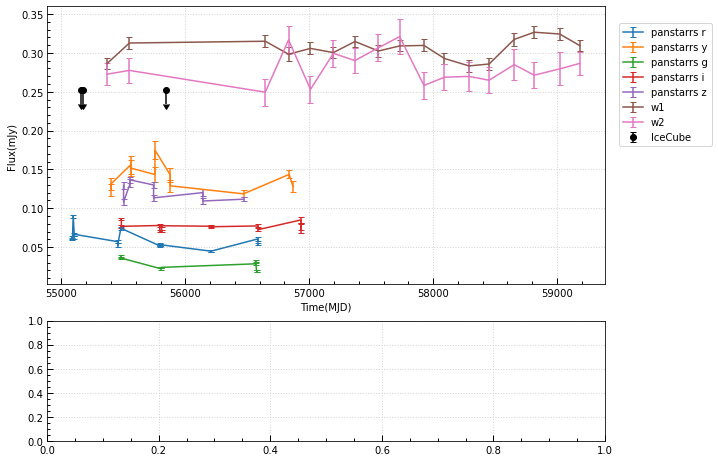

  3%|▎         | 1/30 [00:01<00:40,  1.39s/it]

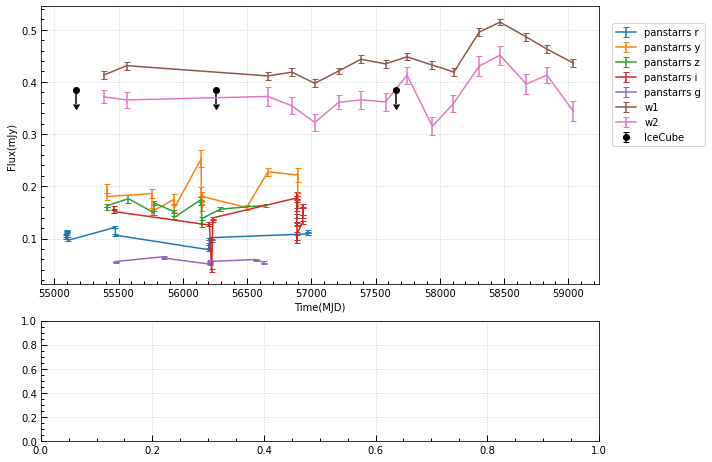

  7%|▋         | 2/30 [00:02<00:39,  1.39s/it]

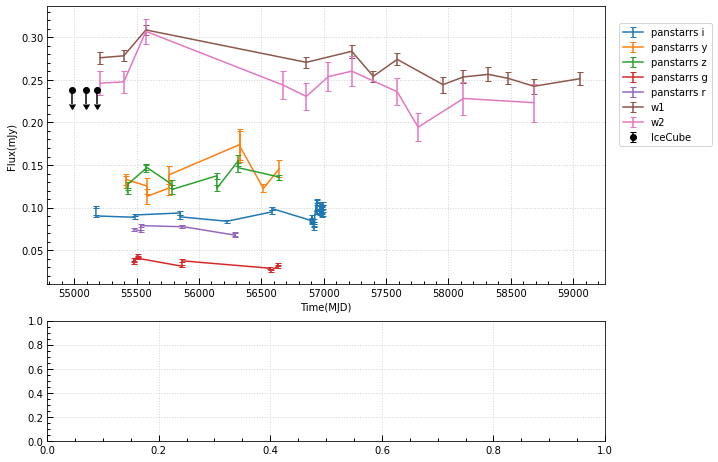

 10%|█         | 3/30 [00:04<00:37,  1.39s/it]

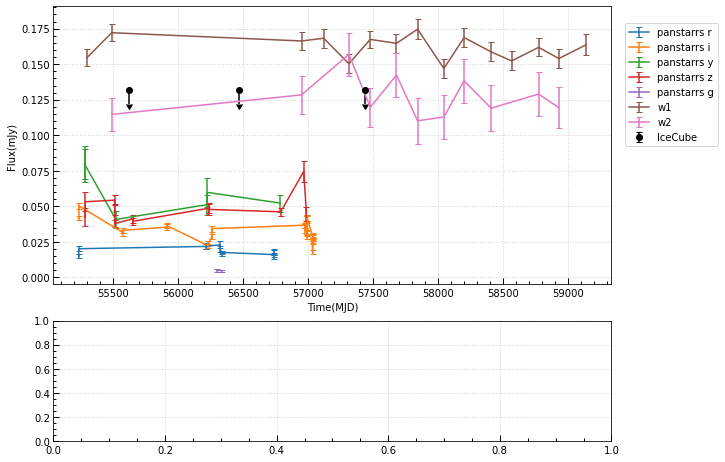

 13%|█▎        | 4/30 [00:05<00:37,  1.46s/it]

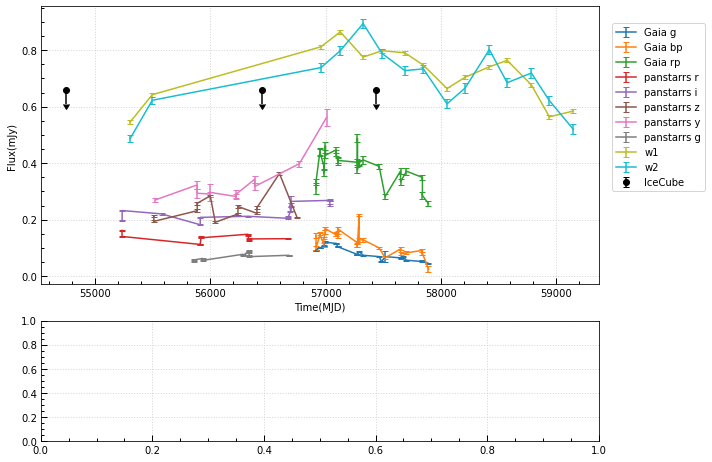

100%|██████████| 30/30 [00:29<00:00,  1.01it/s]

Done


In [6]:
_ = create_figures(coords_list = coords_list ,
                   df_lc = parallel_df_lc, # either df_lc (serial call) or parallel_df_lc (parallel call)
                   show_nbr_figures = 5,
                   save_output_dir = "/home/jovyan/fornax-demo-notebooks/light_curves/data" ,
                  )

## References

This work made use of:

- Astroquery; Ginsburg et al., 2019, 2019AJ....157...98G

- Astropy; Astropy Collaboration 2022, Astropy Collaboration 2018, Astropy Collaboration 2013, 2022ApJ...935..167A, 2018AJ....156..123A, 2013A&A...558A..33A

- Lightkurve; Lightkurve Collaboration 2018, 2018ascl.soft12013L

- acstools; https://zenodo.org/record/7406933#.ZBH1HS-B0eY

- unTimely; Meisner et al., 2023, 2023AJ....165...36M

- Alerce; Forster et al., 2021, 2021AJ....161..242F